In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#prepare object points e.g (0,0,0) (1,0,0)...(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) #x, y coordinates

#arrays to store object points and image points from all images
objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane

#read in all calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

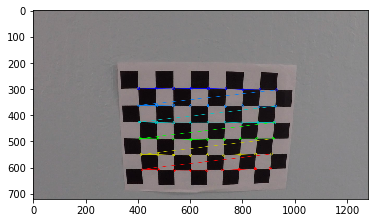

In [3]:
#step through calibration image list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = gray.shape[::-1] #for later use
    
    #find chessboard corners for this image
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        #draw an image for visualization
        if i == 8:
            img_corners = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imshow(img_corners)
            

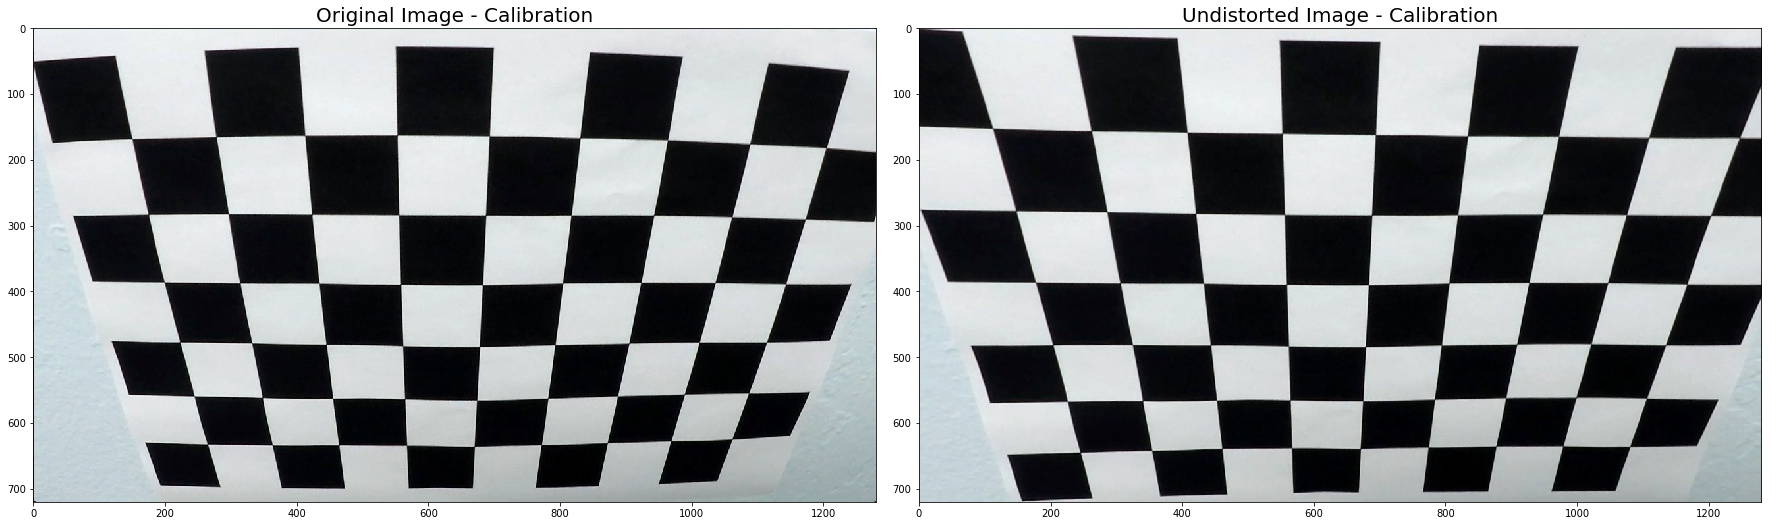

In [4]:
#calculate the camera matrix for calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

#read in a reference calibration image for visualization of undistortion
ref_img_calib = cv2.imread('./camera_cal/calibration2.jpg')
#undistort this ref image
ref_img_calib_undist = cv2.undistort(ref_img_calib, mtx, dist, None, mtx)
    
#visualize a comparison of distorted and undistorted
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(ref_img_calib)
ax1.set_title('Original Image - Calibration', fontsize=20)
ax2.imshow(ref_img_calib_undist)
ax2.set_title('Undistorted Image - Calibration', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

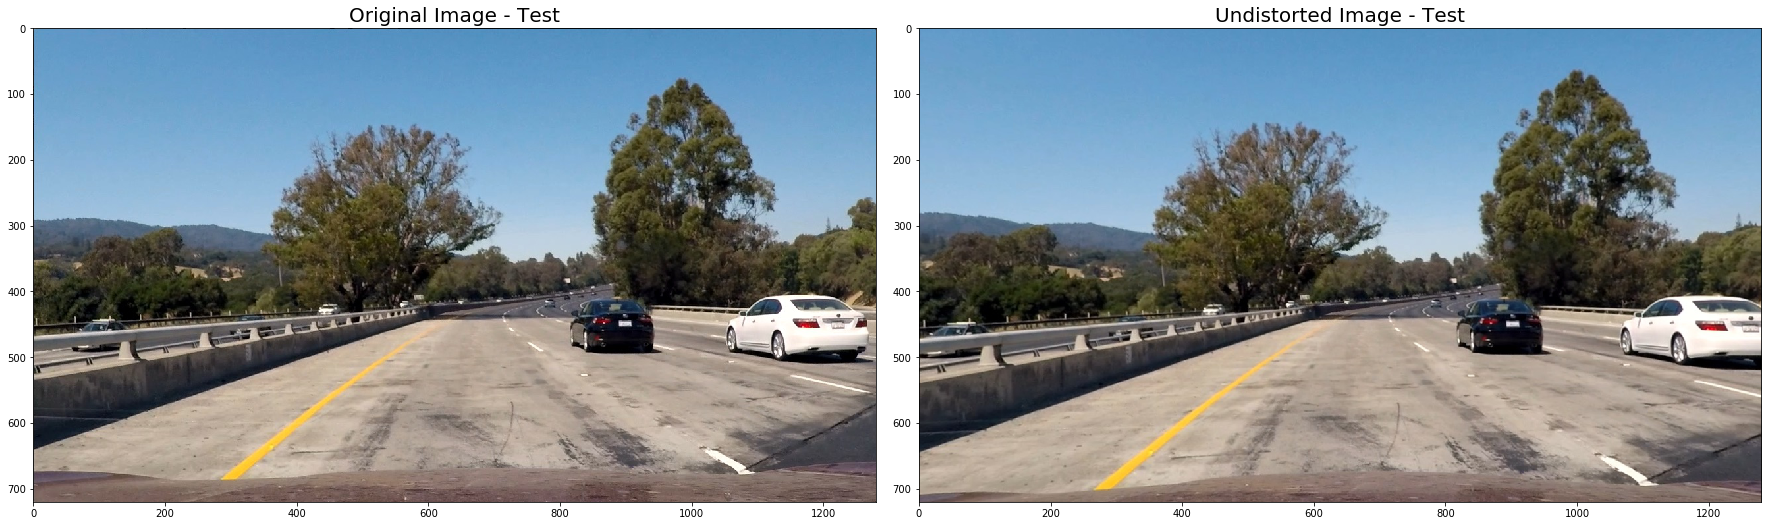

In [5]:
#read in a reference test image for visualization of undistortion
ref_img_test = cv2.imread('./test_images/test1.jpg')
#undistort this ref image
ref_img_test_undist = cv2.undistort(ref_img_test, mtx, dist, None, mtx)
    
#visualize a comparison of distorted and undistorted test image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(ref_img_test, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image - Test', fontsize=20)
ax2.imshow(cv2.cvtColor(ref_img_test_undist, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image - Test', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
#SUPPORTING FUNCTIONS FOR THRESHOLDING
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integers
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS and V-channel for HSV
def color_threshold(img, s_thresh=(0, 255), v_thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_output = np.zeros_like(s_channel)
    s_output[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_output = np.zeros_like(v_channel)
    v_output[(v_channel > v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    binary_output = np.zeros_like(v_channel)
    binary_output[(s_output == 1) & (v_output == 1)] = 1
    return binary_output

In [7]:
#function for warping the image
def warper(image, test= False):
    #setup region of interest for transform
    img_size = (image.shape[1], image.shape[0])
    botw = 0.76 #width of the trapeziodal region at the bottom
    midw = 0.08 #width of the trapeziodal region at the mid 
    height = 0.62 #height of the trapeziodal region
    bot_crop = 0.935 #crop the bottom part of the image where the car hood is
    offset = img_size[0]*0.25 #for the rectangular region in the transform
    x1, y1 = img_size[0]*(.5-midw/2), img_size[1]*height
    x2, y2 = img_size[0]*(.5+midw/2), img_size[1]*height
    x3, y3 = img_size[0]*(.5-botw/2), img_size[1]*bot_crop
    x4, y4 = img_size[0]*(.5+botw/2), img_size[1]*bot_crop
    src = np.float32([[x1, y1], [x2, y2],[x3, y3], [x4, y4]])
    dst = np.float32([[offset,0], [img_size[0]-offset, 0],  [offset, img_size[1]], [img_size[0]-offset, img_size[1]]])

    #get the transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    #get the inverse transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    #perform transformation
    binary_warped = cv2.warpPerspective(image, M, img_size)

    if test:
        #write out the transformed image
        result = binary_warped
        write_name = './test_images/transformed/' + str(i) + '.jpg';
        cv2.imwrite(write_name, result)
        
    return binary_warped, M, Minv

In [8]:
#class for tracking
# Define a class to receive the characteristics of each line detection
class tracker():
    def __init__(self, window_w, window_h, margin, y_m = 1, x_m = 1, smoothing = 15):
        # list the stores all past centers values used for smoothing
        self.recent_centers = []  
        # window width used to count pixels inside center windows to determine curve values
        self.window_width = window_w
        # window height used to count pixels inside center windows to determine curve values
        self.window_height = window_h   
        #the distance in pixels for searching left and right
        self.margin = margin  
        #meters per pixel in vertical axis 
        self.ym_per_pix = y_m
        #meters per pixel in horizontal axis 
        self.xm_per_pix = x_m
        #lookback for averaging
        self.smoothing = smoothing

    def find_window_centroids(self, warped):
        window_width = self.window_width
        window_height = self.window_height
        margin = self.margin
        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))

        self.recent_centers.append(window_centroids)

        return np.average(self.recent_centers[-self.smoothing:], axis=0)
        

In [13]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output
    

def process_image(image):
    
    #1. UNDISTORT IMAGE
    image = cv2.undistort(image, mtx, dist, None, mtx)
    
    if test:
        #write out the undistorted image
        result = image
        write_name = './test_images/undistorted/' + str(i) + '.jpg';
        cv2.imwrite(write_name, result)
    
    #2. THRESHOLD IMAGE
    ksize = 3 # Choose a Sobel kernel size
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', thresh=(15, 255))
    grady = abs_sobel_thresh(image, orient='y', thresh=(25, 255))
    #mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    #dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, np.pi/2))
    color_binary = color_threshold(image, s_thresh=(100, 255), v_thresh=(50, 255))
    
    #combine the thresholds
    thresholded = np.zeros_like(image[:,:,0])
    thresholded[((gradx == 1) & (grady == 1) | (color_binary == 1))] = 255
    
    if test:
        #write out the thresholded image
        result = thresholded
        write_name = './test_images/thresholded/' + str(i) + '.jpg';
        cv2.imwrite(write_name, result)
        
    #3. PERPECTIVE TRANSFORM
    warped, M, Minv = warper(thresholded)
    
    #4. CONVOLUTION to determine the curve of the lanes
    # window settings
    window_width = 25 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 25 # How much to slide left and right for searching
    curve_centers = tracker(window_w=window_width, window_h=window_height,margin=margin,y_m=10/720,x_m=4/384, smoothing=15) 
    window_centroids = curve_centers.find_window_centroids(warped)

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    #points used to find left and right lanes
    leftx=[]
    rightx=[]

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas

        #add center value in the frame to the list of left and right lane points
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

        l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0], level)
        r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1], level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    tracked = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    if test: 
        #write out the tracked image
        result = tracked
        write_name = './test_images/tracked/' + str(i) + '.jpg';
        cv2.imwrite(write_name, result)
    
    #5. FIT TO A CURVE the detected lane pixels
    #fit lane boundaries to left, right, center positions found
    yvals = range(0, warped.shape[0])
    res_yvals = np.arange(warped.shape[0] - (window_height/2), 0, -window_height)
    
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals+left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)

    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals+right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0),
                             np.concatenate((yvals,yvals[::-1]), axis=0))), np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),
                             np.concatenate((yvals,yvals[::-1]), axis=0))), np.int32)
    mid_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]-window_width/2), axis=0),
                             np.concatenate((yvals,yvals[::-1]), axis=0))), np.int32)

    #setup for drawing to the original image
    road = np.zeros_like(image)
    road_bg = np.zeros_like(image)
    cv2.fillPoly(road, [left_lane], color=[245,0,0])
    cv2.fillPoly(road, [right_lane], color=[0,0,245])
    if test == False: 
        cv2.fillPoly(road, [mid_lane], color=[0,235,0])
    cv2.fillPoly(road_bg, [left_lane], color=[255,255,255])
    cv2.fillPoly(road_bg, [right_lane], color=[255,255,255])
        
    if test:    
        result = road
        write_name = './test_images/curvefit/' + str(i) + '.jpg'
        cv2.imwrite(write_name, result)
    
    #unwarp the images from the birds eye view to the frontal view
    road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
    road_warped_bg = cv2.warpPerspective(road_bg, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    #write out the road image
    bg = cv2.addWeighted(image, 1.0, road_warped_bg, -1.0, 0.0)
    result = cv2.addWeighted(bg, 1.0, road_warped, 0.7, 0.0)
    
    xm_per_pix = curve_centers.xm_per_pix #meters per pixel in x dim
    ym_per_pix = curve_centers.ym_per_pix #meters per pixel in y dim
    
    #6. FIND RADIUS OF CURVATURE
    #calculate radius of curvature for the left lane and use that
    curve_fit_c = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(leftx, np.float32)*xm_per_pix, 2)
    curvature = ((1 + (2*curve_fit_c[0]*yvals[-1]*ym_per_pix + curve_fit_c[1])**2)**1.5) / np.absolute(2*curve_fit_c[0])
    
    #calculate car position wrt center
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <=0:
        side_pos = 'right'
         
    #show curvature and offset on final image
    cv2.putText(result,'Radius of Curvature = ' + str(round(curvature, 3)) +'m', (50,50), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result,'Car is '+ str(abs(round(center_diff, 3))) +'m ' + side_pos + ' of center',(50,100),cv2.FONT_HERSHEY_COMPLEX,1,(255, 255, 255),2)
    
    if test:    
        write_name = './test_images/road/' + str(i) + '.jpg'
        cv2.imwrite(write_name, result)
        
    return result

In [15]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test = False

if test:
    #read in the test images glob
    test_images = glob.glob('./test_images/test*.jpg')

    #step through and undistort the above test images
    for i, fname in enumerate(test_images):
        image = cv2.imread(fname)
        process_image(image)
else:
    output_video = 'output1.mp4'
    input_video = 'project_video.mp4'

    clip1 = VideoFileClip(input_video)
    video_clip = clip1.fl_image(process_image)
    %time video_clip.write_videofile(output_video, audio=False)


[MoviePy] >>>> Building video output1.mp4
[MoviePy] Writing video output1.mp4


100%|█████████▉| 1260/1261 [02:40<00:00,  7.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output1.mp4 

CPU times: user 4min 9s, sys: 30.7 s, total: 4min 39s
Wall time: 2min 41s
